# Kindle Clippings Parser

Simple Script to Parse Kindle Highlights. Configure path to your file. Script extracts highlights into a CSV export, does some simple data analysis and provides a highlight count by book.

---

In [24]:
# set path to your clippings file
my_path = "My Clippings - Kindle.txt"

-----

In [25]:
# dependencies
from datetime import date, datetime as dt, timedelta as td
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

----

In [26]:
# function to parse and extract kindle highlights from clippings.txt file
# TODO: Add Reference to Adapted Code
def extract_clipping(data):

    meta0 = data[0]
    br_pts0 = [i for i, x in enumerate(meta0) if x == '(']
    if len(br_pts0) == 0:
        book_title = meta0
        author = 'Unknown'
    else:
        br0 = br_pts0[-1]
        book_title = meta0[:br0]
        author = meta0[br0+1:-1]

        if ',' in author:
            parts = author.split(',')
            author = parts[1][1:] + ' ' + parts[0]

        if ';' in author:
            author = author.split(';')

    meta1 = data[1].split('|')
    if len(meta1) == 3:
        num_pages = meta1[0][meta1[0].find('p') + 5:-1]
        location = meta1[1][1:-1]
        br1 = meta1[2].find(',')
        entry_date = dt.strptime(meta1[2][br1+2:], '%B %d, %Y %I:%M:%S %p').strftime("%Y-%m-%d %H:%M:%S")
    elif len(meta1) == 2:
        num_pages = 'Unknown'
        location = meta1[0][meta1[0].find('on') + 3:-1]
        br1 = meta1[1].find(',')
        entry_date = dt.strptime(meta1[1][br1+2:], '%B %d, %Y %I:%M:%S %p').strftime("%Y-%m-%d %H:%M:%S")

    highlight = data[3]
        
    return {
            'book_title': book_title,
            'author': author,
            'num_pages': num_pages,
            'location': location,
            'entry_date': entry_date,
            'highlight': highlight
        }

----

## Parse and Export Kindle Clippings to CSV

In [27]:
# split clippings.txt file into relevant sections
with open(my_path, "r") as file:
    everything = file.read()
    everything = everything.replace('\ufeff', '')
    sections = everything.split('==========\n')
    
# print(len(sections))
    
clippings_list = []
for i, clip in enumerate(sections[:-1]):
    data = clip.split('\n')
    extract = extract_clipping(data)
    clippings_list.append(extract)

# len(clippings_list)

# create dataframe
clippings = pd.DataFrame(clippings_list)

In [28]:
# export to csv
clippings.to_csv("data/clippings.csv", index=None, encoding='utf-8')

----

## Simple Data Check and Data Analysis

In [29]:
my_clippings = pd.read_csv("data/clippings.csv")

In [30]:
my_clippings.columns = ['author', 'book_title', 'timestamp', 'highlight', 'location',
       'num_pages']

In [31]:
print('{:,} total highlights'.format(len(my_clippings)))
print('{:,} total books'.format(len(my_clippings['book_title'].unique())))
print('{:,} total authors'.format(len(my_clippings['author'].unique())))

12,107 total highlights
381 total books
184 total authors


In [32]:
# date additions
my_clippings['timestamp'] = pd.to_datetime(my_clippings['timestamp'])
my_clippings['my_clippings'] = my_clippings['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d')) # note: not very efficient
my_clippings['year'] = my_clippings['timestamp'].dt.year
my_clippings['month'] = my_clippings['timestamp'].dt.month
my_clippings['mnth_yr'] = my_clippings['timestamp'].apply(lambda x: x.strftime('%Y-%m')) # note: not very efficient
my_clippings['day'] = my_clippings['timestamp'].dt.day
my_clippings['dow'] = my_clippings['timestamp'].dt.weekday
my_clippings['hour'] = my_clippings['timestamp'].dt.hour

In [33]:
my_clippings.tail()

,author,book_title,timestamp,highlight,location,num_pages,my_clippings,year,month,mnth_yr,day,dow,hour
12102,Jeff Bercovici,Play On,2018-05-19 00:29:22,Kaatsu. It’s an updated version of a technique...,Location 1368-1370,90,2018-05-19,2018,5,2018-05,19,5,0
12103,Jeff Bercovici,Play On,2018-05-19 00:31:19,“What exercise actually is is blood flowing to...,Location 1391-1393,91,2018-05-19,2018,5,2018-05,19,5,0
12104,Jeff Bercovici,Play On,2018-05-19 00:41:06,Trapping blood in the limbs puts the brain in ...,Location 1471-1473,96,2018-05-19,2018,5,2018-05,19,5,0
12105,Jeff Bercovici,Play On,2018-05-19 00:43:13,transcranial direct-current stimulation (TDCS).,Location 1493-1493,98,2018-05-19,2018,5,2018-05,19,5,0
12106,Jeff Bercovici,Play On,2018-05-19 00:44:34,“neuropriming”: the mild current lowers the ac...,Location 1509-1510,99,2018-05-19,2018,5,2018-05,19,5,0


----

## Highlights by Book

In [34]:
book_highlights = my_clippings['book_title'].value_counts().sort_values()

In [35]:
# book_most_highlighted = book_highlights.head(30)
(pd.DataFrame(book_highlights)).to_csv("data/book_highlights_count.csv", encoding='utf-8')

In [36]:
book_highlights_count = pd.read_csv("data/book_highlights_count.csv")

In [37]:
book_highlights_count.columns = ['book_title', 'count']

In [38]:
book_most_highlighted = book_highlights_count.tail(30)

In [39]:
# TODO: Trim long titles

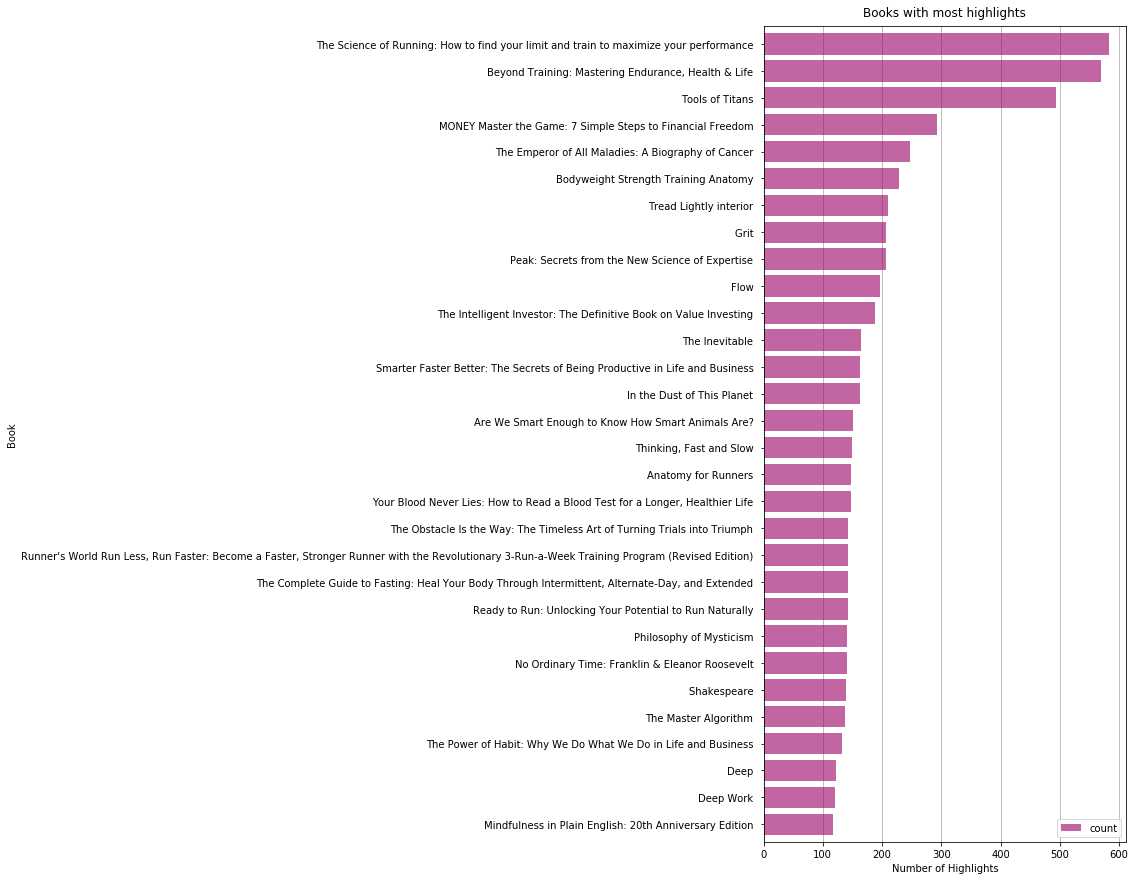

In [40]:
ax = book_most_highlighted.plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)

n_groups = len(book_most_highlighted)
index = np.arange(n_groups)

ax.xaxis.grid(True)
ax.set_xlabel('Number of Highlights')
ax.set_ylabel("Book")
plt.yticks(index, book_most_highlighted.book_title)

ax.set_title('Books with most highlights', y=1.005)

# plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

----

## Analysis by Year

In [41]:
year_counts = my_clippings['year'].value_counts().sort_index()
year_counts

2014     397
2015     633
2016    4357
2017    5531
2018    1189
Name: year, dtype: int64

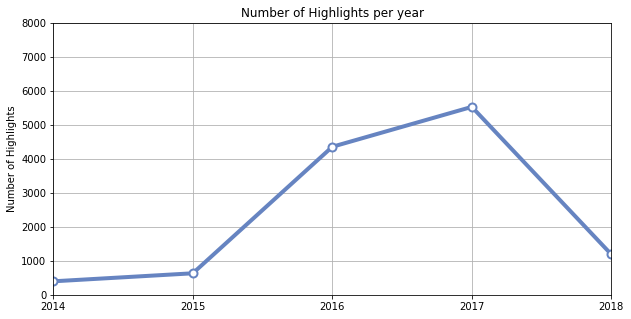

In [42]:
dataset = year_counts
chart_title = 'Number of Highlights per year'

ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 8000)
ax.set_xticks(dataset.index)
ax.set_ylabel('Number of Highlights')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()

-----

## Monthly Analysis

In [43]:
month_counts = my_clippings['mnth_yr'].value_counts().sort_index()
month_counts.columns = ['Count']
# month_counts

In [44]:
# not every month necessarily has a highlight, so fill in missing months with zero counts
#date_range = pd.date_range(start=min(highlights_10['timestamp']), end=max(highlights_10['timestamp']))
#months_range = date_range.map(lambda x: str(x.date())[:-3])
#index = np.unique(months_range)
# month_counts = month_counts.reindex(index, fill_value=0)

In [45]:
# total months
len(month_counts)

49

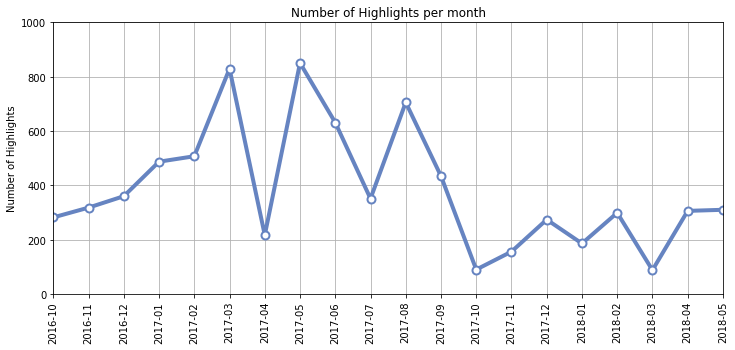

In [46]:
# a bit of a hackish solution, could use improvement
dataset = month_counts.tail(20)
chart_title = 'Number of Highlights per month'

n_groups = len(dataset)
index = np.arange(n_groups)

ax = dataset.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

# ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 1000)
ax.set_xticks(index)
ax.set_ylabel('Number of Highlights')
# ax.set_xlabel('')
plt.xticks(index, dataset.index, rotation=90)
ax.set_title(chart_title)

plt.show()